<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
# Version control:
# keras 2.4.3
# tensorflow 2.1.0
# numpy 1.19.0
# seaborn 0.10.0
# flask 1.1.1
# python 3.6.10
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


### Task 2: Plot Sample Image

<function matplotlib.pyplot.show>

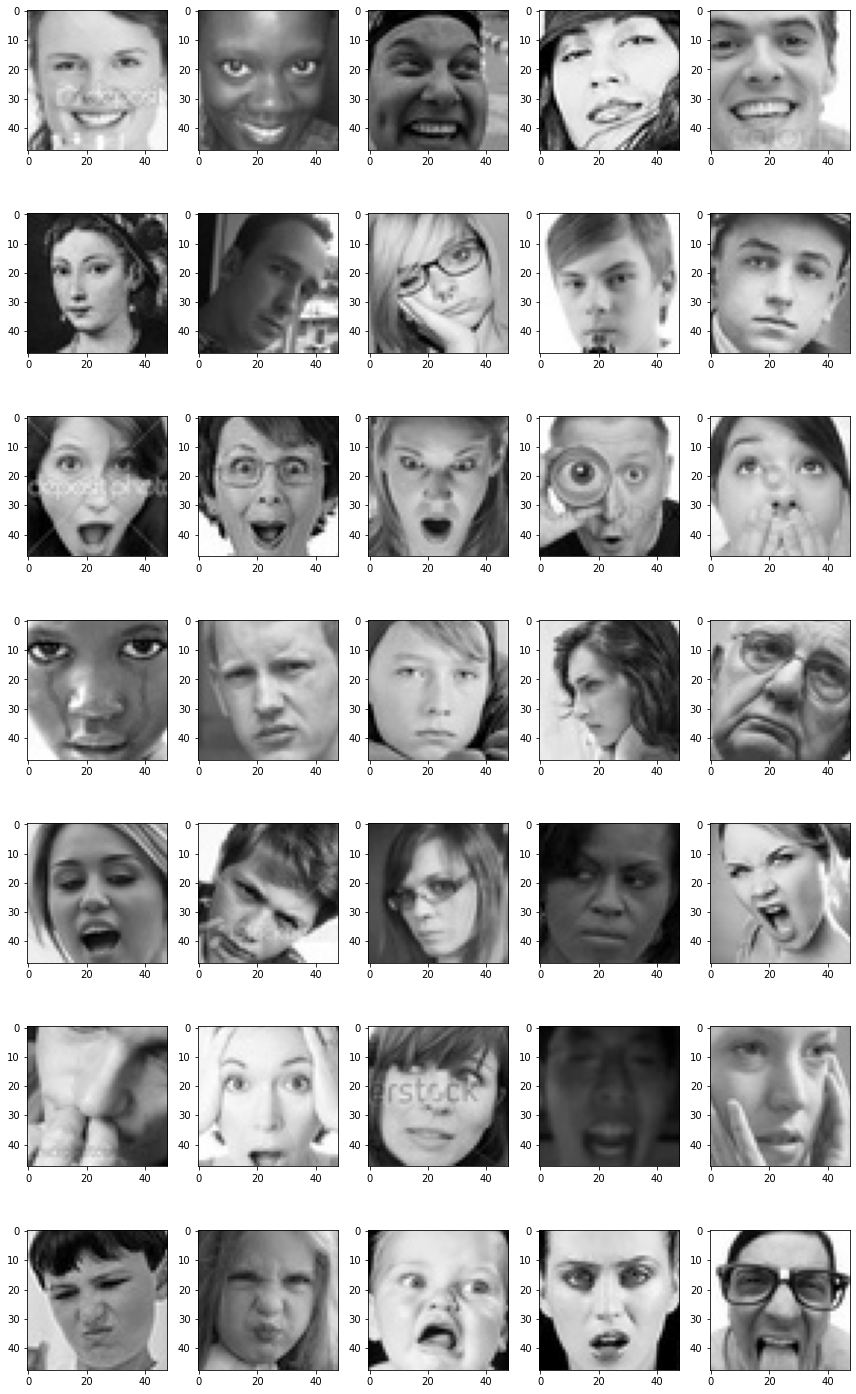

In [2]:
utils.datasets.fer.plot_example_images(plt).show

In [3]:
for expression in os.listdir("test/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + "images")

7215 happyimages
4965 neutralimages
3171 surpriseimages
4830 sadimages
3995 angryimages
4097 fearimages
436 disgustimages


### Task 3: Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

datagen_val = ImageDataGenerator(horizontal_flip=True)
val_generator = datagen_train.flow_from_directory("test/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [5]:
# Model of type sequential used because it is easy to stack sequential layers and in
# some cases reccurent layers, consisting of only 1 input tensor and 1 output tensor
model = Sequential()

# Creating seven layers of the CNN

# Conv2D is a Keras feature which provides a 2D convolution layer for blurring, sharpening,
# embosing, edge detection and more by doing a convolution between a kernel and an image.
# The mandtory parameter is the number of filters the Convlution layer will learn from, it
# is an integer value ranging as the power of 2. Also a tuple can be provided for the dimensions
# of the kernel (in this case (3,3), this parameter must be an odd integer). padding is used to
# either reduce spacial dimension using 'valid', as required or perserving spacial dimension using
# 'same'. input_shape is used to provide the shape or dimensions of the input
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())            # Used to improve speed, performance and stability by re-centering and re-scaling
model.add(Activation('relu'))              # Using ReLU (Rectified Linear Unit) activation
model.add(MaxPooling2D(pool_size=(2,2)))   # Use max pooling to reduce spacial dimension of output volume
model.add(Dropout(0.25))                   # Used for reducing overfitting and performing model averaging

model.add(Conv2D(128, (5,5), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# creating a 1D array to create a single long feature layer of the output from various
# convolution layers
model.add(Flatten()) 

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

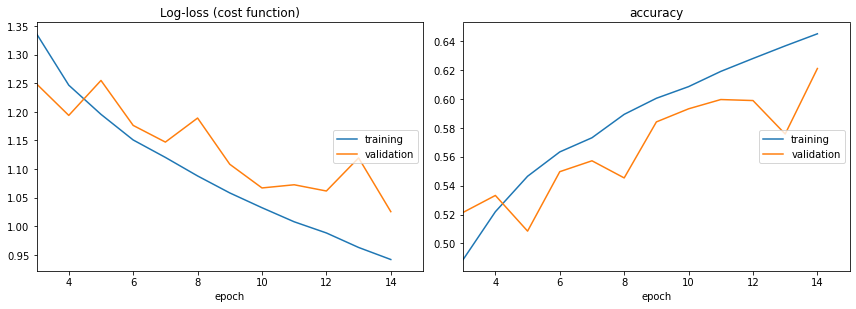

Log-loss (cost function):
training   (min:    0.942, max:    1.814, cur:    0.942)
validation (min:    1.025, max:    1.725, cur:    1.025)

accuracy:
training   (min:    0.308, max:    0.645, cur:    0.645)
validation (min:    0.356, max:    0.621, cur:    0.621)

Epoch 00014: saving model to model_weights.h5
448/448 [==============================] - 698s 2s/step - loss: 0.9417 - accuracy: 0.6451 - val_loss: 1.0254 - val_accuracy: 0.6211
Epoch 15/15
447/448 [============================>.] - ETA: 1s - loss: 0.9144 - accuracy: 0.6555

In [ ]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

# To save best weights, arguments are: name of file (uses h5 file), on what
# factor to save best weights, mode of factor (in case of best weights use max),
# and verbose
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)

# To reduce learning rate when there is no improvement in the gradient decsent
# after a certain number of epochs, argumets are: on what factor to redusce lr,
# how much reduction in lr, how many epochs to waut before reduction, minimum
# lr, and mode of model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')

# PlotLossesKeras(): Helper function provided by livelossplot for small scale models.
# It's ideal because it provides visual log of training and is used as a custom 
# callback with keras
callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

### Task 7: Represent Model as JSON String

In [ ]:
model_json=model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)